In [1]:
%%capture
!pip install langgraph
!pip install langchain_openai
!pip install langchain_core
!pip install pygraphviz


In [2]:
!apt-get install -y graphviz libgraphviz-dev
!pip install pygraphviz --no-binary=pygraphviz --force-reinstall


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 

In [3]:
from langgraph.graph import StateGraph, END, START
from langgraph.types import Send
from typing import TypedDict, Annotated, List, Literal
from pydantic import BaseModel, Field
import operator
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import display, Image
from pprint import pprint
from google.colab import userdata



In [5]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7, api_key=userdata.get('OPENAI_API_KEY'))

In [4]:
class RouterState(TypedDict):
    user_input: str
    task_type: str
    output: str

In [6]:
class Router(BaseModel):
    role: str = Field(..., description="Decide whether the user wants to summarize a passage  ouput 'summarize'  or translate text into French oupput translate.")
llm_router=llm.bind_tools([Router])

In [7]:
response=llm_router.invoke("summarize this I love the sun its so warm")

In [13]:
print(response.tool_calls[0]['args'])


{'role': 'summarize'}


In [14]:
def router_node(state: RouterState) -> RouterState:
    routing_prompt = f"""
    You are an AI task classifier.

    Decide whether the user wants to:
    - "summarize" a passage
    - or "translate" text into French

    Respond with just one word: 'summarize' or 'translate'.

    User Input: "{state['user_input']}"
    """

    response = llm_router.invoke(routing_prompt)

    return {**state, "task_type": response.tool_calls[0]['args']['role']} # This becomes the next node's name!

In [15]:
def router(state: RouterState) -> str:
    return state['task_type']

In [17]:
def summarize_node(state: RouterState) -> RouterState:
    prompt = f"Please summarize the following passage:\n\n{state['user_input']}"
    response = llm.invoke(prompt)

    return {**state, "task_type": "summarize", "output": response.content}

In [18]:
def translate_node(state: RouterState) -> RouterState:
    prompt = f"Translate the following text to French:\n\n{state['user_input']}"
    response = llm.invoke(prompt)

    return {**state, "task_type": "translate", "output": response.content}

In [20]:
workflow = StateGraph(RouterState)


In [21]:
workflow.add_node("router", router_node)
workflow.add_node("summarize", summarize_node)
workflow.add_node("translate", translate_node)

In [22]:
workflow.set_entry_point("router")

In [23]:
workflow.add_conditional_edges("router", router, {
    "summarize": "summarize",
    "translate": "translate"
})

In [24]:
workflow.set_finish_point("summarize")
workflow.set_finish_point("translate")

In [25]:
app = workflow.compile()


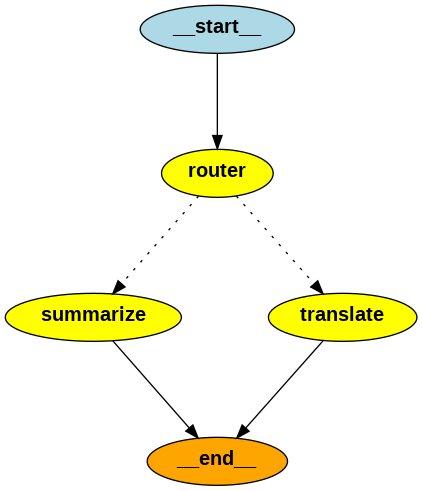

In [26]:
display(Image(app.get_graph().draw_png()))

In [27]:
input_text = {
        "user_input": "Can you translate this sentence: I love programming?"
    }

result = app.invoke(input_text)

In [29]:
print(result[ 'output'])
print(result['task_type'])

Sure! The translation of "I love programming" in French is "J'aime la programmation."
translate


In [30]:
input_text = {
        "user_input": "Can you summarize this sentence: I love programming so much it is the best thing ever. All I want to do is programming?"
    }

result = app.invoke(input_text)

In [31]:
print(result[ 'output'])
print(result['task_type'])

The speaker expresses a deep passion for programming, considering it the most enjoyable activity and their primary desire.
summarize
